In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter, freqz, filtfilt

sampling_rate = 25

In [2]:
fir_coefficients = [
         0.000000000000000008,
        -0.000000000000000010,
        -0.000000000008613790,
        -0.000000000307895541,
        -0.000000002132651724,
        -0.000000007553824243,
        -0.000000016938276671,
        -0.000000025380250830,
        -0.000000023426302108,
        -0.000000005807519207,
        0.000000017590114797,
        0.000000022963557544,
        -0.000000005710770755,
        -0.000000049167002338,
        -0.000000052514791223,
        0.000000029655446176,
        0.000000172656003391,
        0.000000272899118874,
        0.000000230455273658,
        0.000000070407902425,
        -0.000000023965885458,
        0.000000149580193617,
        0.000000580396516004,
        0.000000948804625759,
        0.000000849815417850,
        0.000000246492317132,
        -0.000000251374145643,
        0.000000249624054846,
        0.000001774163029313,
        0.000001902718876582,
        -0.000004032263539140,
        0.000014801961183948,
        0.000012947388888072,
        -0.000197250142727958,
        -0.000701867769249823,
        -0.001193844962413906,
        -0.001158424656994665,
        -0.000621944876714104,
        -0.000666342492380998,
        -0.002690836139410751,
        -0.006615861485188978,
        -0.009949523188414147,
        -0.009637520217605475,
        -0.005866507442850112,
        -0.003803551357312558,
        -0.009784488323214657,
        -0.023912274426761811,
        -0.036635410442335065,
        -0.035519157151293224,
        -0.018746295013495291,
        -0.002284959037935996,
        -0.009610912057634634,
        -0.048283783422300913,
        -0.093656821556688183,
        -0.099211329390539671,
        -0.031713967156537716,
        0.095342998354334546,
        0.220649798528040536,
        0.272878609613148471,
        0.220649798528039037,
        0.095342998354334768,
        -0.031713967156537654,
        -0.099211329390539463,
        -0.093656821556687725,
        -0.048283783422300733,
        -0.009610912057634388,
        -0.002284959037935942,
        -0.018746295013495284,
        -0.035519157151293224,
        -0.036635410442335141,
        -0.023912274426761804,
        -0.009784488323214689,
        -0.003803551357312552,
        -0.005866507442850079,
        -0.009637520217605446,
        -0.009949523188414107,
        -0.006615861485188996,
        -0.002690836139410759,
        -0.000666342492380996,
        -0.000621944876714109,
        -0.001158424656994662,
        -0.001193844962413902,
        -0.000701867769249812,
        -0.000197250142727948,
        0.000012947388888068,
        0.000014801961183941,
        -0.000004032263539135,
        0.000001902718876585,
        0.000001774163029312,
        0.000000249624054857,
        -0.000000251374145619,
        0.000000246492317150,
        0.000000849815417859,
        0.000000948804625749,
        0.000000580396516006,
        0.000000149580193626,
        -0.000000023965885452,
        0.000000070407902427,
        0.000000230455273677,
        0.000000272899118881,
        0.000000172656003390,
        0.000000029655446163,
        -0.000000052514791229,
        -0.000000049167002345,
        -0.000000005710770754,
        0.000000022963557542,
        0.000000017590114809,
        -0.000000005807519199,
        -0.000000023426302112,
        -0.000000025380250843,
        -0.000000016938276679,
        -0.000000007553824244,
        -0.000000002132651723,
        -0.000000000307895534,
        -0.000000000008613775,
        0.000000000000000005,
        0.000000000000000019,
]

# FIR bandpass filter with frequency range [0.4-4 Hz]
def custom_fir_filter(signal, coefficients):
    # Length of the signal and the filter
    n = len(signal)
    m = len(coefficients)
#     print(f'data lenght: {n}, coeff length: {m}')

    # Initialize the output signal with zeros
    filtered_signal = [0] * n

    # Apply the FIR filter
    for i in range(n):
        for j in range(m):
            if i - j >= 0:  # Check to avoid negative indices
                filtered_signal[i] += coefficients[j] * signal[i - j]
    return filtered_signal

In [3]:
def noise_discard(ppg_signal, accel_signal, accel_threshold, sliding_window_sec):
    
    sliding_window_size = sliding_window_sec * sampling_rate 
    total_samples = len(accel_signal)
    noisy_batch_count = 0
    quiet_batch_count = 0
    
    ppg_remove_indices = pd.DataFrame(columns=['from', 'to'])
    ppg_remain_indices = pd.DataFrame(columns=['from', 'to'])
    
    denoised_ppg = np.array([])
    denoised_accel = np.array([])
    
    for i in range(0, total_samples, sliding_window_size):
        batch_5s_accel = accel_signal[i:i+sliding_window_size]
        batch_5s_ppg = ppg_signal[i:i+sliding_window_size]
        row_data = {'from': i, 'to': i+sliding_window_size}
        
        if np.mean(np.abs(batch_5s_accel)) > accel_threshold:
            noisy_batch_count = noisy_batch_count + 1            
            ppg_remove_indices = ppg_remove_indices.append(row_data, ignore_index=True)
        else :
            denoised_ppg = np.append(denoised_ppg, batch_5s_ppg)
            denoised_accel = np.append(denoised_accel, batch_5s_accel)
            quiet_batch_count = quiet_batch_count + 1
                        
            ppg_remain_indices = ppg_remain_indices.append(row_data, ignore_index=True)

    discard_ratio = noisy_batch_count / (noisy_batch_count + quiet_batch_count)
    discard_ratio = round(discard_ratio, 2)
    
    return denoised_accel, denoised_ppg, discard_ratio, ppg_remove_indices, ppg_remain_indices

def hr_measurement(ppg_signal, sample_rate):
    # Find peaks
    peaks, _ = find_peaks(ppg_signal, distance=sample_rate*0.4)  # distance based on expected heart rate range

    # Calculate time between peaks in seconds
    peak_times = peaks / sample_rate
    time_diffs = np.diff(peak_times)

    # Calculate heart rate
    # Average time difference between peaks
    avg_time_diff = np.mean(time_diffs)

    heart_rate = 60 / avg_time_diff  # Convert to beats per minute (BPM)
    heart_rate = round(heart_rate, 2)
    
    return heart_rate, peaks, time_diffs

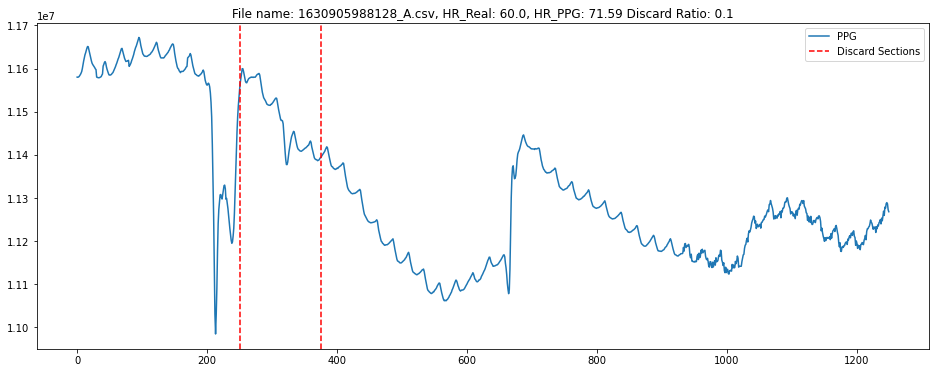

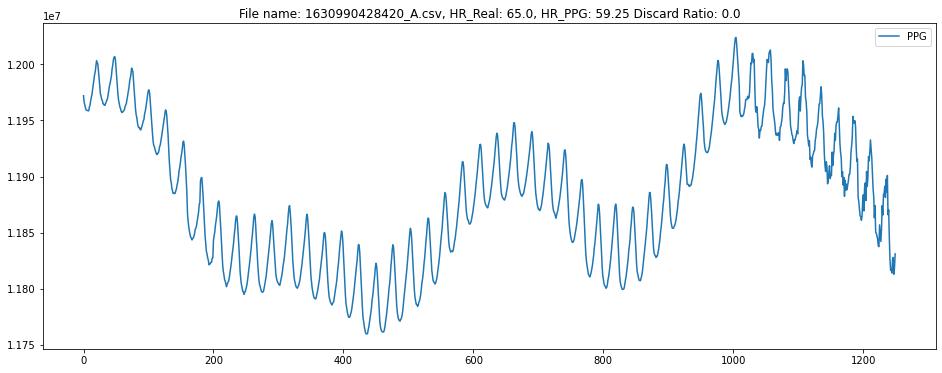

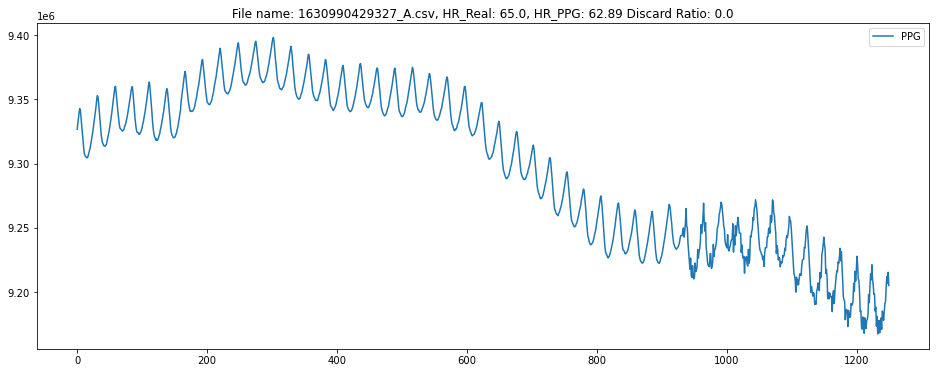

In [4]:
noisy_database_c_path = "C:/Users/peiha/Desktop/C_Project/ppg_data_noisy"

sliding_window_sec = 5
accel_threshold = 0.39
counting = 0

for file_path in glob.glob(f'{noisy_database_c_path}/*.csv'):
    if counting < 3:
        df = pd.read_csv(file_path)
        
        file_name = os.path.basename(file_path)
        real_hr = df['HR'][0]
        
        counting = counting + 1
        
        cols = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']
        accel_1 = (df[cols][250:]**2).sum(axis=1)**0.5
        normalized_accel = (accel_1 - accel_1.mean()) / accel_1.std()
        normalized_accel = normalized_accel.values
        filtered_accel = custom_fir_filter(normalized_accel, fir_coefficients)

        original_ppg = df['AFEData1'][250:].values
        original_ppg = original_ppg
        normalized_ppg = (original_ppg - original_ppg.mean()) / original_ppg.std()
        filtered_ppg = custom_fir_filter(normalized_ppg, fir_coefficients)
        
        denoised_accel, denoised_ppg, discard_ratio, ppg_remove_indices, ppg_remain_indices = \
        noise_discard(filtered_ppg, filtered_accel, accel_threshold, sliding_window_sec)
        
        rr_time = []
        if discard_ratio < 1:
            for index, row in ppg_remain_indices.iterrows():
                begin_index = row['from']
                end_index = row['to']
                batched_ppg = filtered_ppg[begin_index:end_index]
                batched_hr, peaks, time_diffs = hr_measurement(batched_ppg, sampling_rate)
                rr_time = np.append(rr_time, time_diffs)
            measured_hr = np.mean(rr_time)
            measured_hr = 60 / measured_hr
            measured_hr = round(measured_hr, 2)
        else:
            measured_hr = 0
        
        plt.figure(figsize=(16, 6))
#         plt.plot(filtered_accel, label='Accel')
        plt.plot(original_ppg, label='PPG')
        plt.title(f'File name: {file_name}, HR_Real: {real_hr}, HR_PPG: {measured_hr} Discard Ratio: {discard_ratio}')
        
        for index, row in ppg_remove_indices.iterrows():
            plt.axvline(x=row['from'], color='red', linestyle='--', label='Discard Sections')
            plt.axvline(x=row['to'], color='red', linestyle='--')

        
        plt.legend()

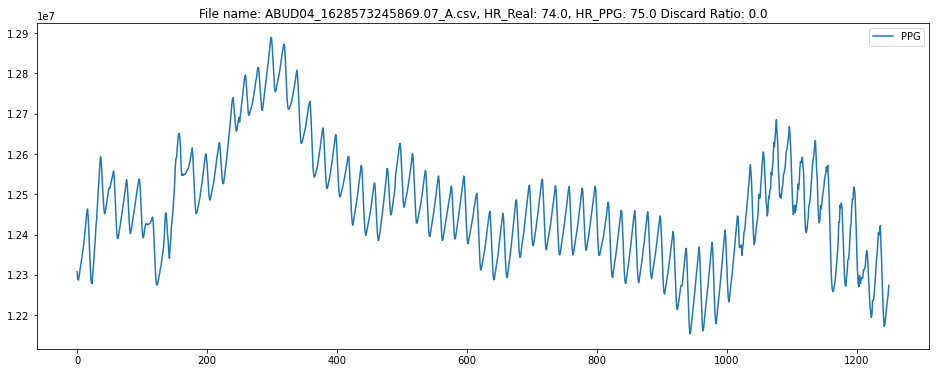

In [5]:
file_path = "C:/Users/peiha/Desktop/C_Project/ppg_data/ABUD04_1628573245869.07_A.csv"

df = pd.read_csv(file_path)

file_name = os.path.basename(file_path)
real_hr = df['HR'][0]
cols = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']
accel_1 = (df[cols][250:]**2).sum(axis=1)**0.5
normalized_accel = (accel_1 - accel_1.mean()) / accel_1.std()
normalized_accel = normalized_accel.values
filtered_accel = custom_fir_filter(normalized_accel, fir_coefficients)

original_ppg = df['AFEData1'][250:].values
original_ppg = original_ppg
normalized_ppg = (original_ppg - original_ppg.mean()) / original_ppg.std()
filtered_ppg = custom_fir_filter(normalized_ppg, fir_coefficients)

denoised_accel, denoised_ppg, discard_ratio, ppg_remove_indices, ppg_remain_indices = \
noise_discard(original_ppg, filtered_accel, accel_threshold, sliding_window_sec)

rr_time = []
if discard_ratio < 1:
    for index, row in ppg_remain_indices.iterrows():
        begin_index = row['from']
        end_index = row['to']
        batched_ppg = filtered_ppg[begin_index:end_index]
        batched_hr, peaks, time_diffs = hr_measurement(batched_ppg, sampling_rate)
        rr_time = np.append(rr_time, time_diffs)
    measured_hr = np.mean(rr_time)
    measured_hr = 60 / measured_hr
    measured_hr = round(measured_hr, 2)
else:
    measured_hr = 0

plt.figure(figsize=(16, 6))
#plt.plot(filtered_accel, label='Accel')
plt.plot(original_ppg, label='PPG')
plt.title(f'File name: {file_name}, HR_Real: {real_hr}, HR_PPG: {measured_hr} Discard Ratio: {discard_ratio}')

for index, row in ppg_remove_indices.iterrows():
    plt.axvline(x=row['from'], color='red', linestyle='--', label='Discard Sections')
    plt.axvline(x=row['to'], color='red', linestyle='--')


plt.legend()